In [1]:
# Cell 1: Imports and global config
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import mlflow
import mlflow.keras
from mlflow import system_metrics

import psutil  # For system monitoring

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [3]:
# Cell 2: Start run + log system/environment info
mlflow.end_run()  # Safe to call even if no run is active

# Now start fresh
mlflow.set_experiment("Churn_Prediction_New")
run = mlflow.start_run(run_name="Run_" + pd.Timestamp.now().strftime("%Y%m%d_%H%M%S"))
print("✅ Started new run:", run.info.run_id)

# Log system info
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("framework", "TensorFlow/Keras")
mlflow.log_param("dataset", "Churn_Modelling.csv")

# Log hardware info
mlflow.log_param("cpu_count", psutil.cpu_count())
mlflow.log_param("total_ram_gb", round(psutil.virtual_memory().total / (1024**3), 2))

# Enable system metrics logging (MLflow ≥2.10+)
# This populates the "System Metrics" tab in UI
system_metrics.enable_system_metrics_logging()

2025/12/27 17:54:58 INFO mlflow.tracking.fluent: Experiment with name 'Churn_Prediction_New' does not exist. Creating a new experiment.


✅ Started new run: a6f30a9388cf438da731177b9bd520b4


In [4]:
# Cell 3: Load and preprocess data
dataset = pd.read_csv('Churn_Modelling.csv')
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, 13].values

# Encode Gender (column index 2)
labelencoder_gender = LabelEncoder()
X[:, 2] = labelencoder_gender.fit_transform(X[:, 2])

# OneHotEncode Geography (column index 1)
ct = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(drop='first'), [1])],
    remainder='passthrough'
)
X = ct.fit_transform(X).astype(np.float64)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

mlflow.log_param("input_features", X_train.shape[1])
mlflow.log_param("train_size", X_train.shape[0])
mlflow.log_param("test_size", X_test.shape[0])

2000

In [5]:
# Cell 4: Build model + enable auto-logging
mlflow.keras.autolog(log_models=False)  # We'll log model manually for clarity

classifier = Sequential([
    Dense(6, activation='relu', input_shape=(X_train.shape[1],), name="Hidden_1"),
    Dense(6, activation='relu', name="Hidden_2"),
    Dense(1, activation='sigmoid', name="Output")
])

classifier.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Log architecture manually (optional)
mlflow.log_param("hidden_layers", 2)
mlflow.log_param("units_per_layer", 6)
mlflow.log_param("optimizer", "Adam")
mlflow.log_param("learning_rate", 0.001)

0.001

In [6]:
# Cell 5: Train with EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,
    verbose=1
)

history = classifier.fit(
    X_train, y_train,
    batch_size=10,
    epochs=50,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Log final training metrics
final_epoch = len(history.history['loss'])
mlflow.log_metric("epochs_trained", final_epoch)
mlflow.log_metric("final_train_acc", history.history['accuracy'][-1])
mlflow.log_metric("final_val_acc", history.history['val_accuracy'][-1])

Epoch 1/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7531 - loss: 0.5229 - val_accuracy: 0.8100 - val_loss: 0.4438
Epoch 2/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7944 - loss: 0.4519 - val_accuracy: 0.8100 - val_loss: 0.4228
Epoch 3/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7962 - loss: 0.4344 - val_accuracy: 0.8175 - val_loss: 0.4068
Epoch 4/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8093 - loss: 0.4166 - val_accuracy: 0.8238 - val_loss: 0.3886
Epoch 5/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8164 - loss: 0.4018 - val_accuracy: 0.8375 - val_loss: 0.3756
Epoch 6/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8263 - loss: 0.3898 - val_accuracy: 0.8512 - val_loss: 0.3642
Epoch 7/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8354 - loss: 0.3794 - val_accuracy: 0.8562 - val_loss: 0.3530
Epoch 8/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8433 - loss: 0.3706 - val_accuracy: 0.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


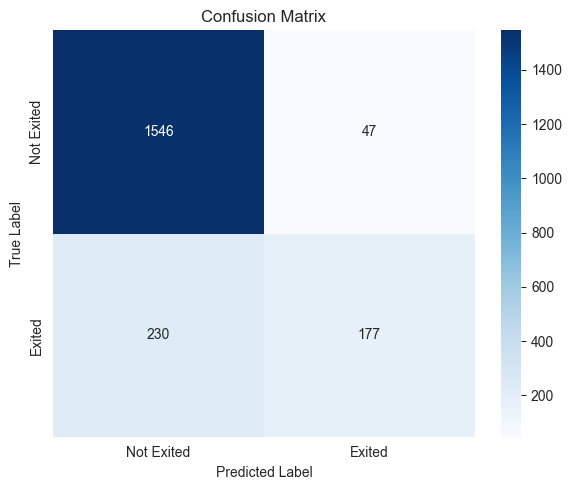

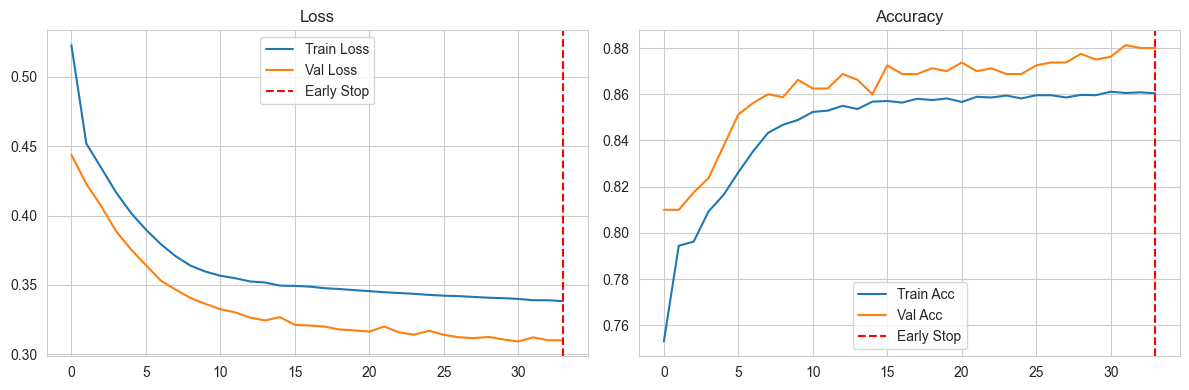

In [7]:
# Cell 6: Evaluate and log results
y_pred_prob = classifier.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

mlflow.log_metric("test_accuracy", acc)

# Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Exited', 'Exited'],
            yticklabels=['Not Exited', 'Exited'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
mlflow.log_artifact("confusion_matrix.png")
plt.show()

# Training History Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axvline(x=final_epoch - 1, color='r', linestyle='--', label='Early Stop')
plt.legend(); plt.title('Loss'); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.axvline(x=final_epoch - 1, color='r', linestyle='--', label='Early Stop')
plt.legend(); plt.title('Accuracy'); plt.grid(True)

plt.tight_layout()
plt.savefig("training_history.png")
mlflow.log_artifact("training_history.png")
plt.show()

# Log detailed metrics from classification report
for class_label, metrics in report.items():
    if isinstance(metrics, dict):
        for metric_name, value in metrics.items():
            mlflow.log_metric(f"{class_label}_{metric_name}", value)

In [8]:
# Cell 7: Log model and end run
# Log full model (with signature for production)
mlflow.keras.log_model(classifier, "ann_model")

# Optional: log scaler for inference pipeline
import joblib
joblib.dump(sc, "scaler.pkl")
mlflow.log_artifact("scaler.pkl")

print("✅ Logging complete. Ending MLflow run.")
mlflow.end_run()

2025/12/27 17:58:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/27 17:58:37 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


✅ Logging complete. Ending MLflow run.
